[A beautiful case from dyfluid](https://mp.weixin.qq.com/s/0PjOnv09LerabVSZyp-g9Q), called **Buckley-Leverett Equation**.

$$
\partial_t \rho + \partial_x\left( \frac{\rho^2}{\rho^2 + \frac{1}{2}(1 - \rho)^2} \right) = 0
$$

Let's frist take a look at the direction of characteristic lines:

In [1]:
import sympy as sm
rho = sm.Symbol('rho')
F = rho**2 / (rho**2 + (1 - rho)**2/2)
dFdr = sm.simplify(sm.diff(F, rho))
sm.factor(dFdr)
# dFdr
# sm.plot(dFdr)

-4*rho*(rho - 1)/(3*rho**2 - 2*rho + 1)**2

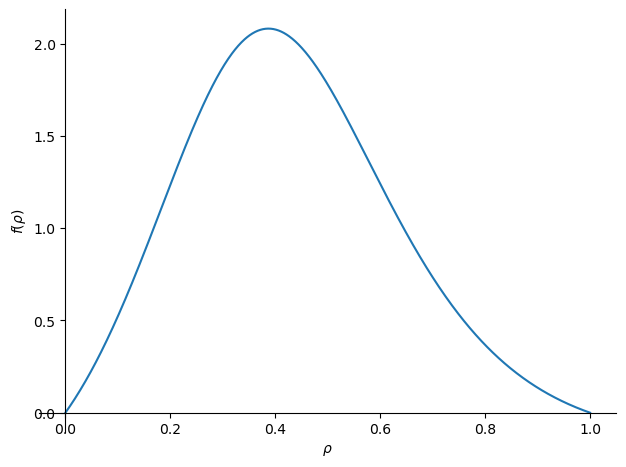

In [2]:
# sm.plot(F, (rho, 0, 1))
sm.plot(dFdr, (rho, 0, 1))

Okey, all the characteristic lines are going to the right!

In [3]:
def flux(u):
    return u**2 / (u**2 + (1 - u)**2/2)

Consider Riemann Solver:
$$
\partial_t u + \partial_x f(u) = 0 \\
\frac{\rm d}{{\rm d}t} \bar{u}_{i} = \frac{1}{h} \left( f^{n}_{i-1/2} - f^{n}_{i+1/2} \right) \\
u^{n+1}_i - u^{n}_i = \frac{\Delta t}{h} \left( f^{n}_{i-1/2} - f^{n}_{i+1/2} \right) \\
\partial_u f \geq 0, f^{n}_{i+1/2} = f(u^{n}_{i}) \\
u^{n+1}_i - u^{n}_i = \frac{\Delta t}{h} \left( f(u^{n}_{i-1}) - f(u^{n}_{i}) \right)
$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from math import isclose

N = 200
L = 20.
h = L/N
dt = h/10
x = np.linspace(-h/2, L + h/2, N + 2)
u = np.zeros(N + 2) # including 2 ghost cells on both ends, thus u[i] is u_i in the formula
Flux = np.zeros(N + 1) # flux[i] stands for f_{i-1/2} in the formula
def initialize(u):
    u[:] = 0
    u[0] = 1

def computeFlux1st(u, Flux):
    Flux[:] = flux(u[:-1])

def update(u: np.array, dt: float):
    u[1:-1] += dt/h * (Flux[:-1] - Flux[1:])

t_sample = [3., 5., 8., 10.]
def sample(t):
    for ts in t_sample:
        if isclose(ts, t):
            return True
    return False

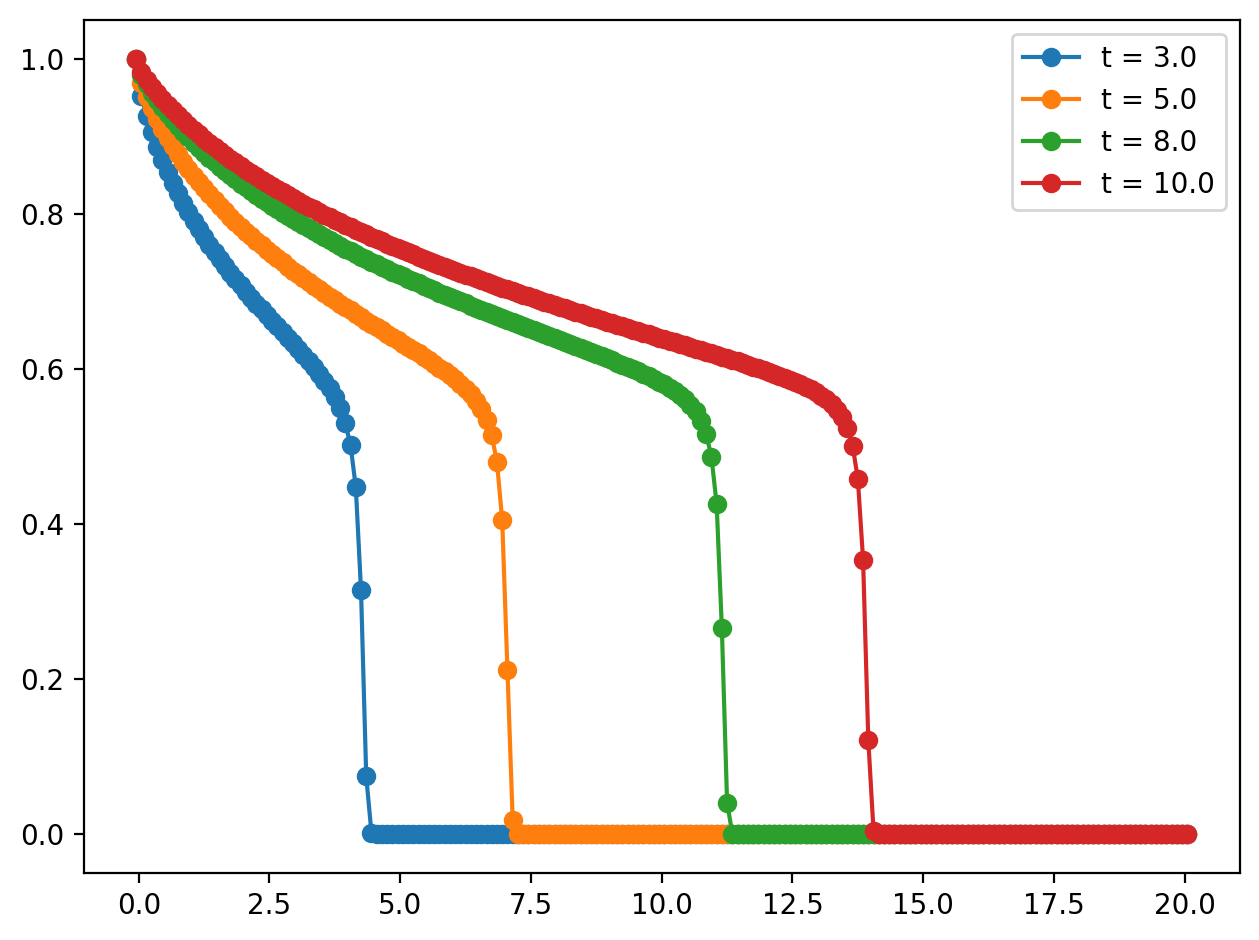

In [5]:
t = 0.
end_t = 10.

initialize(u)
while(t <= end_t):
    computeFlux1st(u, Flux)
    update(u, dt)
    t += dt
    if sample(t):
        plt.plot(x, u, "o-", label = f"t = {t:.1f}")
plt.legend()
plt.tight_layout()
plt.savefig("play1", dpi = 300)

In [6]:
# muscl reconstruction
def minmod(a, b):
    return np.where((a > 0) & (b > 0), np.minimum(a, b),
                    np.where((a < 0) & (b < 0), np.maximum(a, b), 0))

def mclim(a, b):
    two_a = 2 * a
    two_b = 2 * b
    a_plus_b = a + b
    min_vals = np.minimum(np.minimum(two_a, two_b), a_plus_b)
    max_vals = np.maximum(np.maximum(two_a, two_b), a_plus_b)
    return np.where((a > 0) & (b > 0), min_vals,
                    np.where((a < 0) & (b < 0), max_vals, 0))

def computeFlux2nd(u, Flux, limiter = minmod):
    Flux[0] = flux(u[0])
    Flux[N] = flux(u[N])
    # for i in range(1, N):
    #     Flux[i] = flux(u[i] + minmod(u[i] - u[i-1], u[i+1] - u[i])/2)
    Flux[1:N] = flux(u[1:N] + limiter(u[1:N] - u[0:N-1], u[2:N+1] - u[1:N])/2)


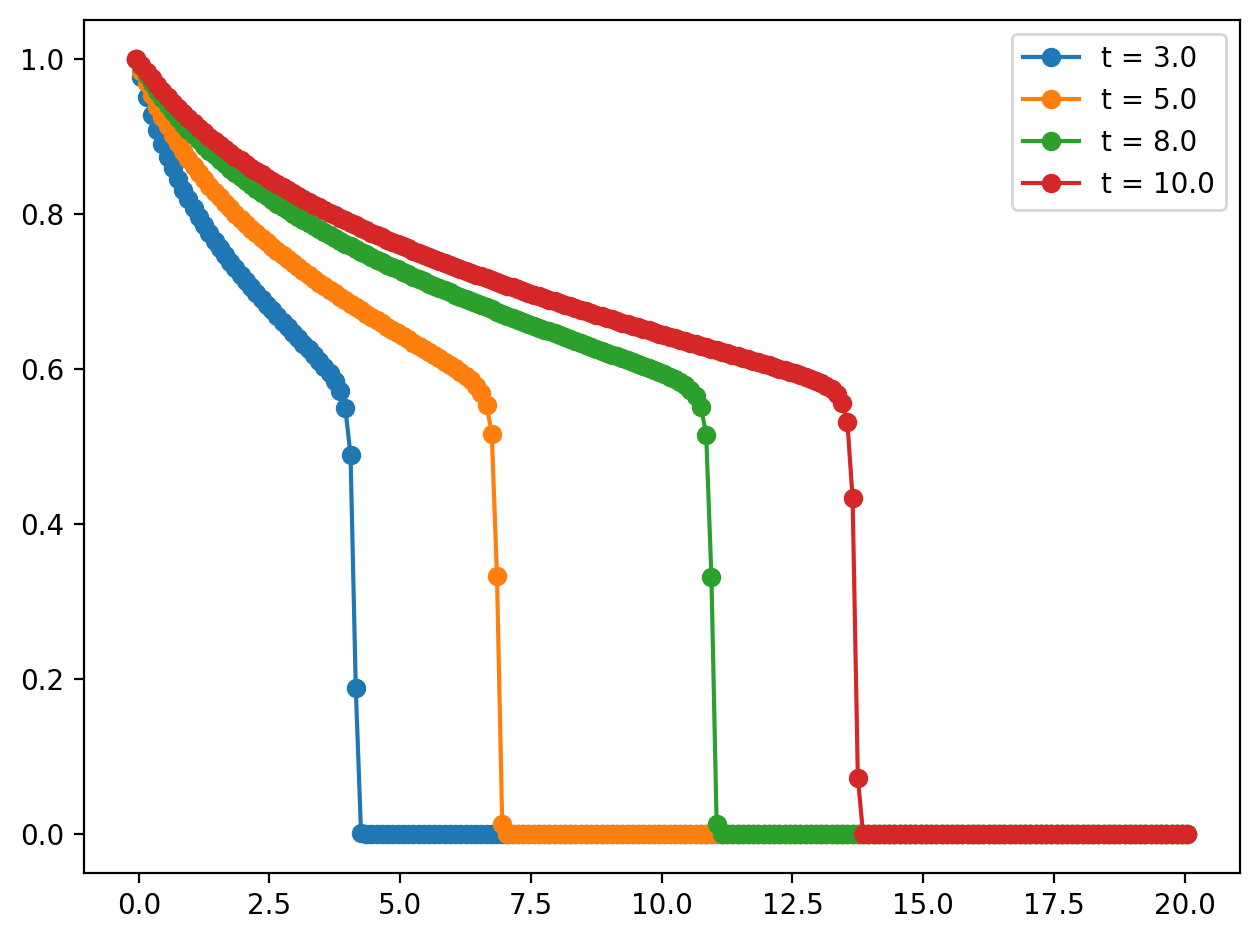

In [7]:
t = 0.
end_t = 10.

initialize(u)
while(t <= end_t):
    computeFlux2nd(u, Flux, minmod)
    update(u, dt)
    t += dt
    if sample(t):
        plt.plot(x, u, "o-", label = f"t = {t:.1f}")
plt.legend()
plt.tight_layout()
plt.savefig("play2", dpi = 300)

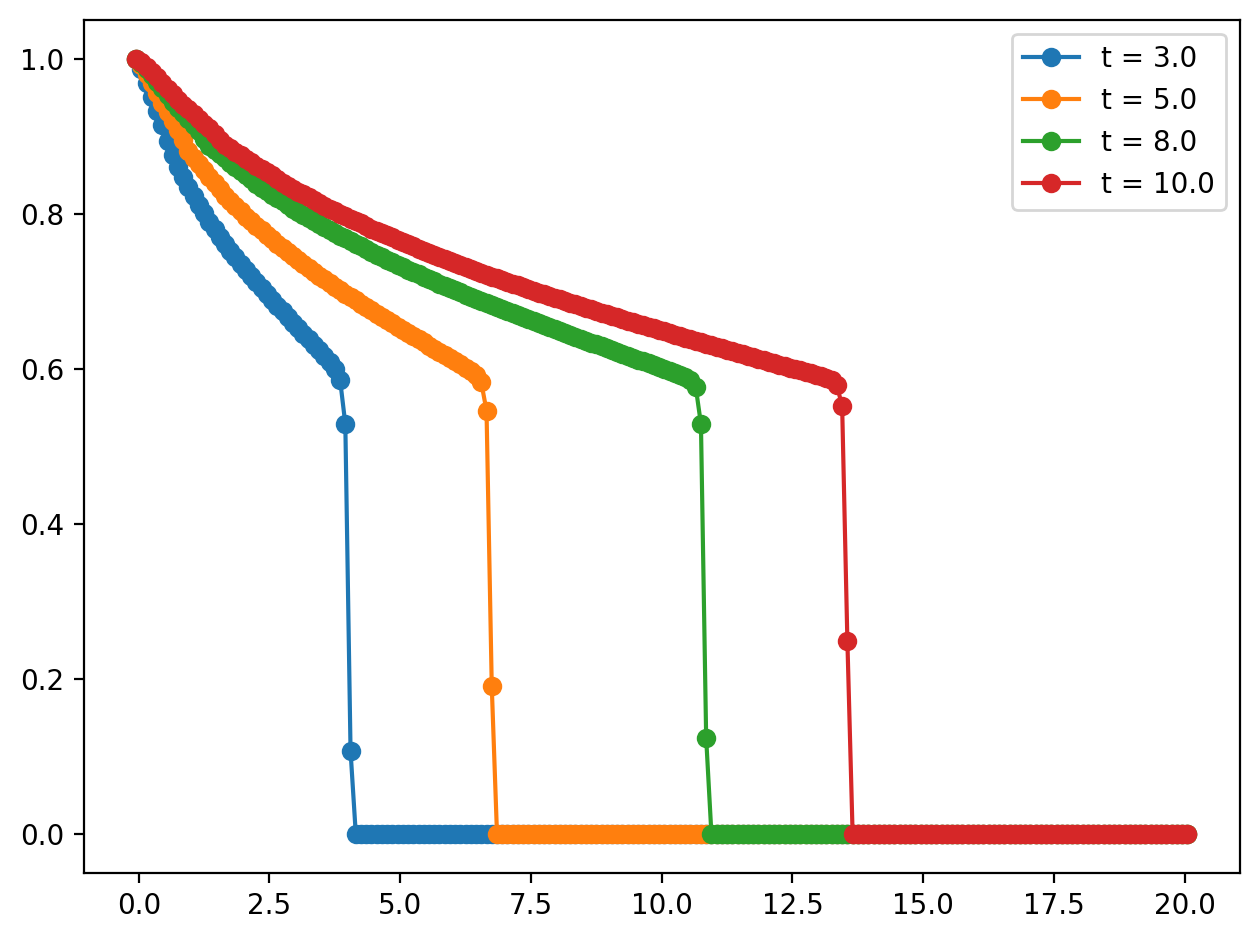

In [8]:
t = 0.
end_t = 10.

initialize(u)
while(t <= end_t):
    computeFlux2nd(u, Flux, mclim)
    update(u, dt)
    t += dt
    if sample(t):
        plt.plot(x, u, "o-", label = f"t = {t:.1f}")
plt.legend()
plt.tight_layout()
plt.savefig("play3", dpi = 300)